In [1]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [2]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-01-23 07:24:15--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.57.194
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.57.194|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?aUMDjaytujBh6hEieqtN5NsaMzdNVpj1r75AkkEmY85pC29PEJrl-tCO4NeS1oULfYfcWvU9AZ0oOvS9b7zvupXPuexk_QJfo4slwooft4gh7X7jbX-lBxL5cx_XLPYdxZpc7l0iYMv9VCmFl4deTSqquuIz4XMJoXG9HKeUwHdKx5GU6NEpUtBMAyFJqMdTuPsFmVCpZvs27iS0_5I [following]
--2021-01-23 07:24:16--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?aUMDjaytujBh6hEieqtN5NsaMzdNVpj1r75AkkEmY85pC29PEJrl-tCO4NeS1oULfYfcWvU9AZ0oOvS9b7zvupXPuexk_QJfo4slwooft4gh7X7jbX-lBxL5

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [4]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git


  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-2v4yn3za
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-2v4yn3za
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4308 sha256=54ff2fccac3548bd9cc53ed91f1bcbc4d2f27cd6632260afde1780c716674f41
  Stored in directory: /tmp/pip-ephem-wheel-cache-m4xqlpl3/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [108]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [199]:
%%cu

#include <stdlib.h>
#include <stdio.h>

#define N 200000

__global__ void bitonic_sort_step(float *gpu_numbers, int j, int k)
{
    unsigned int i, ixj;
    i = threadIdx.x + blockDim.x * blockIdx.x;
    ixj = i^j;

    if ((ixj) > i) {
        if ((i&k) == 0) {
            if (gpu_numbers[i] > gpu_numbers[ixj]) {
                float temp = gpu_numbers[i];
                gpu_numbers[i] = gpu_numbers[ixj];
                gpu_numbers[ixj] = temp;
            }
        }
        if ((i&k) != 0) {
            if (gpu_numbers[i] < gpu_numbers[ixj]) {
                float temp = gpu_numbers[i];
                gpu_numbers[i] = gpu_numbers[ixj];
                gpu_numbers[ixj] = temp;
            }
        }
    }
}

void bitonic_sort(float *numbers)
{
    float *gpu_numbers;

    cudaMalloc((void**) &gpu_numbers, N * sizeof(float));
    cudaMemcpy(gpu_numbers, numbers, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);
    for (int k = 2; k <= N; k <<= 1) {
        for (int j = k>>1; j > 0; j = j>>1) {
            bitonic_sort_step<<<1024, 512>>>(gpu_numbers, j, k);
        }
    }
    cudaMemcpy(numbers, gpu_numbers, N * sizeof(float), cudaMemcpyDeviceToHost);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaFree(gpu_numbers);
 
    float elapsed_time;
    cudaEventElapsedTime(&elapsed_time, start, stop);
    printf("%f, ", elapsed_time);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);
 
}

int main(void)
{
    clock_t start, stop;

    float *numbers = (float*) malloc( N * sizeof(float));
    for (int i = 0; i < N; ++i) {
        numbers[i] = (float)rand()/(float)RAND_MAX;
    }
    for (int i = 0; i < 5; i++) {
        bitonic_sort(numbers);
    }
}

0.861376, 0.832288, 0.827968, 0.810240, 0.807136, 


In [201]:
a

[0.4001152,
 0.4655808,
 0.4705856,
 0.5374272,
 0.5448384,
 0.5523456,
 0.6271552,
 0.6579584,
 0.6460544,
 0.66048,
 0.665408,
 0.6797120000000001,
 0.6874688,
 0.7748223999999999,
 0.7832896,
 0.7872959999999999,
 0.8102912,
 0.814048,
 0.8898111999999999,
 0.8278016000000001]

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline
x = [i for i in range(10000, 210000, 10000)]
y = a



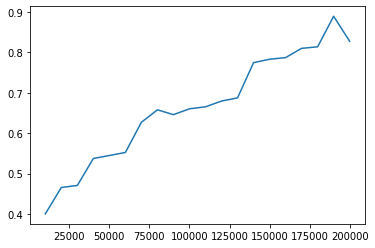

In [203]:
plt.plot(x, y)
